In [2]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


train_file_path = "/kaggle/input/um-game-playing-strength-of-mcts-variants/train.csv"
columns_to_read = ["LudRules", "utility_agent1"]

train = pd.read_csv(train_file_path, usecols=columns_to_read)

train.head()

,LudRules,utility_agent1
0,"(game ""00'Y'"" (players 2) (equipment { (board ...",-0.466667
1,"(game ""00'Y'"" (players 2) (equipment { (board ...",-0.333333
2,"(game ""00'Y'"" (players 2) (equipment { (board ...",-0.066667
3,"(game ""00'Y'"" (players 2) (equipment { (board ...",-0.333333
4,"(game ""00'Y'"" (players 2) (equipment { (board ...",-0.333333


In [3]:
pd.set_option('display.max_colwidth', None)
print(train['LudRules'].iloc[0])

(game "00'Y'" (players 2) (equipment { (board (tri Limping 4) use:Vertex) (piece "Disc" Each) (piece "Counter" Neutral maxState:2) } ) (rules (play (priority { (if (is Prev Mover) (or (move Add (piece (id "Disc" Mover)) (to (sites Occupied by:Next) if:(< (count Pieces Mover in:(sites Around (to) Orthogonal) ) (count Pieces Next in:(sites Around (to) Orthogonal) ) ) (apply (remove (to))) ) ) (move Add (piece (id "Disc" Next)) (to (sites Occupied by:Mover) if:(< (count Pieces Next in:(sites Around (to) Orthogonal) ) (count Pieces Mover in:(sites Around (to) Orthogonal) ) ) (apply (remove (to))) ) ) ) ) (move Add (to (sites Empty)) (then (set Var "MoveInTurn" (% (+ 3 (var "MoveInTurn")) 2) ) ) ) } (then (if (or (= 1 (var "MoveInTurn")) (can Move (or (move Add (piece (id "Disc" Mover)) (to (sites Occupied by:Next) if:(< (count Pieces Mover in:(sites Around (to) Orthogonal ) ) (count Pieces Next in:(sites Around (to) Orthogonal ) ) ) (apply (remove (to))) ) ) (move Add (piece (id "Disc" Nex

# Parse LudRules
This section defines functions to parse the `LudRules` column into structured data. 
The rules are broken down into sections (e.g., `game`, `players`, `equipment`, and `rules`) using regular expressions.

# Extract Features
Features are engineered from the parsed `LudRules`. These include:
- General attributes (e.g., number of players, number of game pieces)
- Complexity metrics (e.g., number of conditions, rule complexity)

# Preprocessing Pipeline
A preprocessing pipeline is created to handle:
1. Missing values in both categorical and numerical features.
2. One-hot encoding of categorical features for model compatibility.

In [4]:
def parse_ludrules(ludrules):
    parsed_data = {}
    patterns = {
        "game": r'\(game\s+"(.*?)"',
        "players": r'\(players\s+(\d+)\)',
        "equipment": r'\(equipment\s+{(.*?)}\s*\)',
        "rules": r'\(rules\s+\((.*)\)\s*\)'
    }
    for key, pattern in patterns.items():
        match = re.search(pattern, ludrules, re.DOTALL)
        parsed_data[key] = match.group(1).strip() if match else None
    return parsed_data

def parse_unique_ludrules(ludrules_series):
    unique_rules = ludrules_series.unique()
    parsed_rules_dict = {rule: parse_ludrules(rule) for rule in unique_rules}
    return ludrules_series.map(parsed_rules_dict)

parsed_ludrules = parse_unique_ludrules(train['LudRules'])
parsed_ludrules_df = pd.DataFrame(parsed_ludrules.tolist())


def extract_features(parsed_df):
    parsed_df['game_name'] = parsed_df['game']
    parsed_df['num_players'] = pd.to_numeric(parsed_df['players'], errors='coerce')
    parsed_df['num_pieces'] = parsed_df['equipment'].apply(lambda x: len(re.findall(r'\(piece', x)) if isinstance(x, str) else 0)
    parsed_df['board_type'] = parsed_df['equipment'].apply(lambda x: re.search(r'\(board \((.*?)\)', x).group(1) if isinstance(x, str) and re.search(r'\(board \((.*?)\)', x) else 'Unknown')
    parsed_df['num_conditions'] = parsed_df['rules'].apply(lambda x: x.count('if') if isinstance(x, str) else 0)
    parsed_df['num_moves'] = parsed_df['rules'].apply(lambda x: x.count('move') if isinstance(x, str) else 0)
    parsed_df['num_triggers'] = parsed_df['rules'].apply(lambda x: x.count('trigger') if isinstance(x, str) else 0)
    parsed_df['rule_complexity'] = parsed_df['rules'].apply(lambda x: len(re.findall(r'[<>=%]', x)) if isinstance(x, str) else 0)
    return parsed_df[['game_name', 'num_players', 'num_pieces', 'board_type', 'num_conditions', 'num_moves', 'num_triggers', 'rule_complexity']]

features = extract_features(parsed_ludrules_df)
target = train['utility_agent1']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


categorical_features = ['game_name', 'board_type']
numerical_features = ['num_players', 'num_pieces', 'num_conditions', 'num_moves', 'num_triggers', 'rule_complexity']

In [5]:
parsed_ludrules_df[categorical_features+numerical_features]

,game_name,board_type,num_players,num_pieces,num_conditions,num_moves,num_triggers,rule_complexity
0,00'Y',tri Limping 4,2.0,2,11,10,1,8
1,00'Y',tri Limping 4,2.0,2,11,10,1,8
2,00'Y',tri Limping 4,2.0,2,11,10,1,8
3,00'Y',tri Limping 4,2.0,2,11,10,1,8
4,00'Y',tri Limping 4,2.0,2,11,10,1,8
...,...,...,...,...,...,...,...,...
233229,Zuz Mel (7x7),square 7,2.0,1,7,4,0,0
233230,Zuz Mel (7x7),square 7,2.0,1,7,4,0,0
233231,Zuz Mel (7x7),square 7,2.0,1,7,4,0,0
233232,Zuz Mel (7x7),square 7,2.0,1,7,4,0,0


In [6]:
from sklearn.impute import SimpleImputer

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)


pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', GradientBoostingRegressor(random_state=42))])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['game_name', 'board_type']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_players', 'num_pieces',
                                                   'num_conditions',
                                                   'num_moves', 'num_triggers',
                                                   'rule_complexity'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [7]:
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Evaluation:\nMAE: {mae}\nMSE: {mse}\nR² Score: {r2}")

feature_names = (
    list(pipeline.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names_out(categorical_features))
    + numerical_features
)
importances = pipeline.named_steps['model'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

Model Evaluation:
MAE: 0.4846648763094844
MSE: 0.35310520929289535
R² Score: 0.09281960446338222


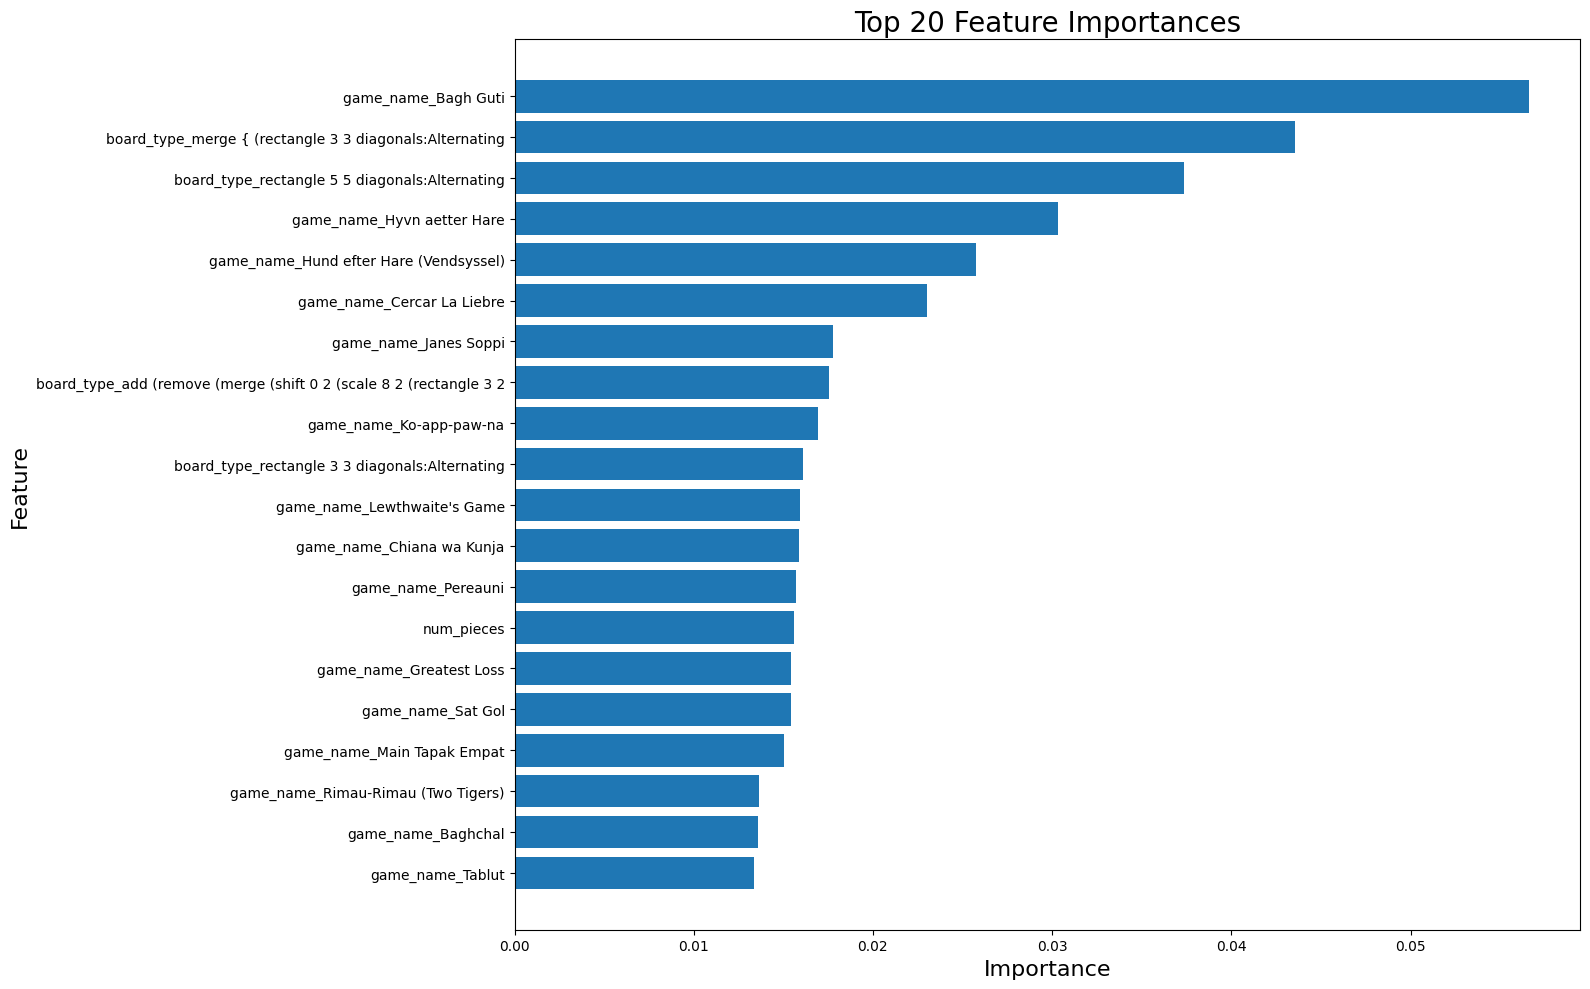

In [8]:
top_20_importance = importance_df.head(20)
plt.figure(figsize=(16, 10))
plt.barh(top_20_importance['Feature'], top_20_importance['Importance'], height=0.8)
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Top 20 Feature Importances', fontsize=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

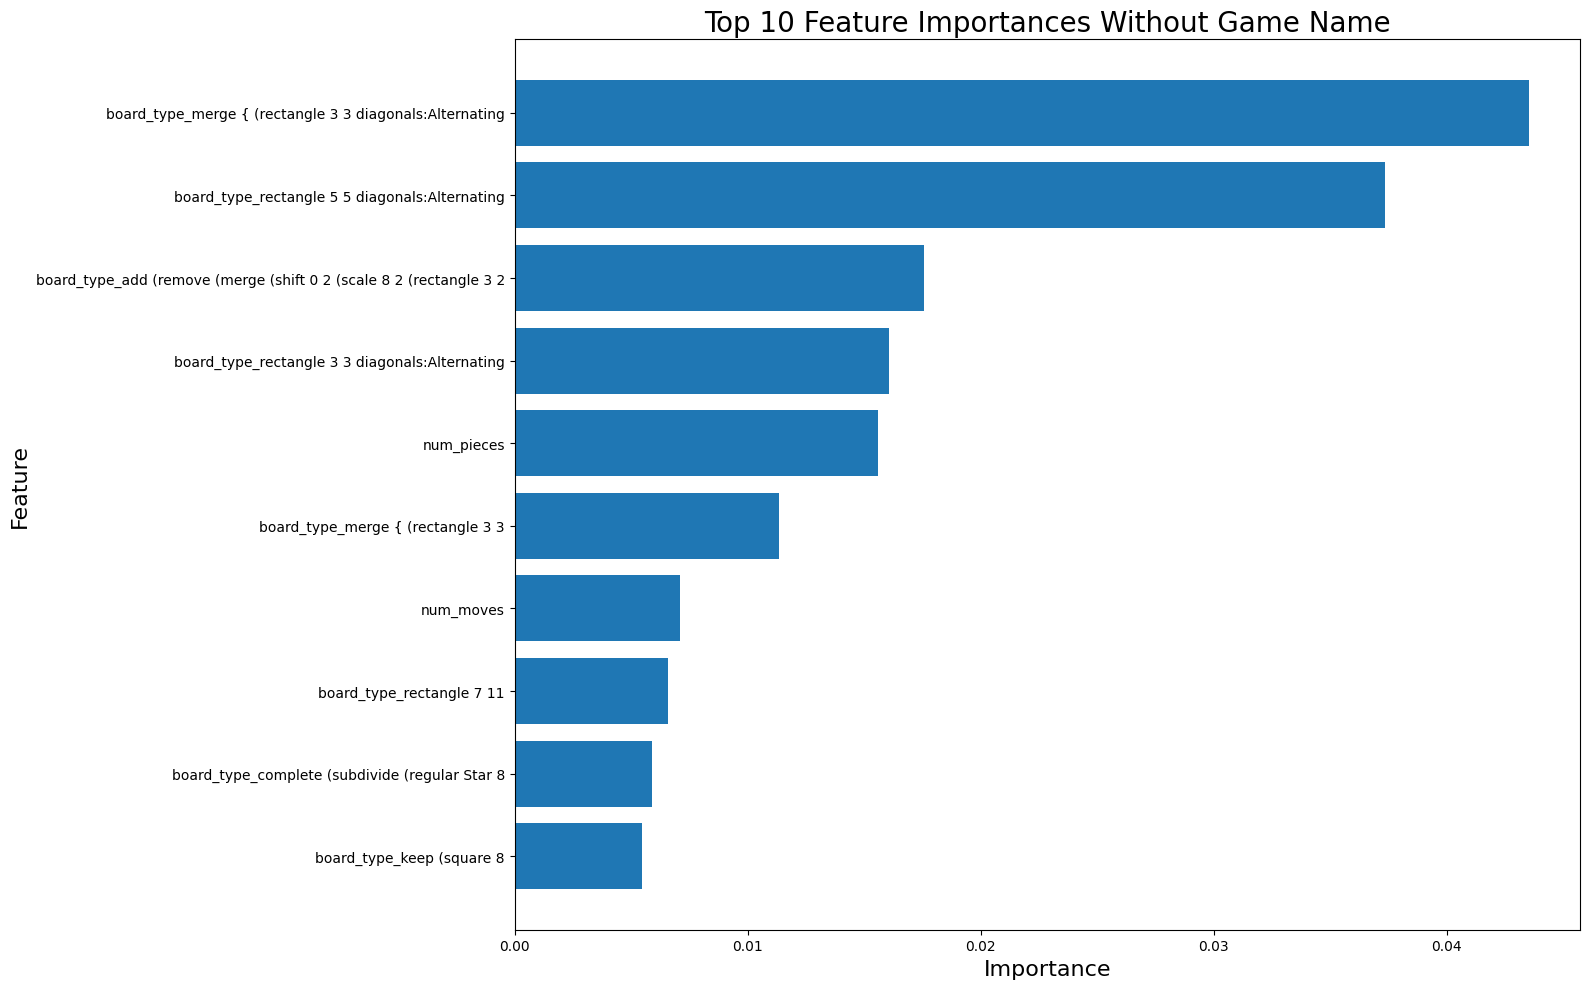

In [9]:
updated_importance_df = importance_df[~importance_df['Feature'].str.contains('game_name')]

top_features = updated_importance_df.head(10) 
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
plt.barh(top_features['Feature'], top_features['Importance'], height=0.8)
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Top 10 Feature Importances Without Game Name', fontsize=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# **Feature Importance**
- Features like **number of pieces**, and **number of moves** were among the most important predictors if we exclude the game name features. 
  - These are generalizable metrics that capture the inherent structure of the games and their rules.
- Specific categorical features like `game_name` or `board_type` were less generalizable, as their importance may vary across datasets.

# **Generalisability of Features**
- Features engineered based on the structure and complexity of rules are likely to generalize better across unseen datasets.
- Categorical features tied to specific games or boards (e.g., `game_name`) are less generalizable.

In [10]:
import joblib

# Save the trained model
model_path = "/kaggle/working/gradient_boosting_model.pkl"
joblib.dump(pipeline, model_path)
print(f"Model saved to {model_path}")

# Code to load the saved model and run inference on new data
def run_inference(new_data, model_path):
    """
    Load the saved model and run inference on new data.

    Parameters:
        new_data (pd.DataFrame): DataFrame containing new input data.
        model_path (str): Path to the saved model.

    Returns:
        np.ndarray: Predicted utility values.
    """
    # Load the saved model
    loaded_model = joblib.load(model_path)
    print("Model loaded successfully.")

    # Run inference
    predictions = loaded_model.predict(new_data)
    return predictions


# Example usage:
# Suppose `new_data` is a DataFrame containing features for inference
# Ensure `new_data` has the same structure (columns) as the training data

# new_data = ...  # Replace with actual DataFrame
# predictions = run_inference(new_data, model_path)
# print("Predictions:", predictions)


Model saved to /kaggle/working/gradient_boosting_model.pkl


In [11]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

download_file('/kaggle/working/gradient_boosting_model.pkl', 'out')

/kaggle/working/out.zip